In [31]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAperture
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import sep
from matplotlib.patches import Ellipse
from astropy.stats import sigma_clipped_stats

In [174]:
im_test='./WCS_Solved/NGC3705/NGC3705_V.fits'
image=fits.open(im_test)[0].data
hdr=fits.open(im_test)[0].header
wcs=WCS(hdr)
data=image.byteswap().newbyteorder()
targets={'NGC3705': SkyCoord("11:30:07 +09:16:36",unit=('hourangle,deg')),
         'MCG05': SkyCoord("17:06:55 +30:16:11",unit=('hourangle,deg')),
         'MCG06': SkyCoord("12:12:05 +32:44:06",unit=('hourangle,deg')),
         'UGC9374': SkyCoord("14:33:59 +40:14:40",unit=('hourangle,deg')),
         'NVSSJ09': SkyCoord("09:24:57 +40:23:59",unit=('hourangle,deg')),
         'NGC6365A': SkyCoord("17:22:44 +62:09:58",unit=('hourangle,deg')),
         'NGC3016': SkyCoord("09:49:51 +12:41:43",unit=('hourangle,deg'))}
target=im_test.split('/')[-2]
target_x,target_y=wcs.world_to_pixel(targets[target])
hdr['FILTER']

'V'

In [175]:
bkg = sep.Background(data)
data_sub=data-bkg.globalback
#objects,seg_map = sep.extract(data_sub, 5, err=bkg.globalrms,segmentation_map=True)
objects,seg_map = sep.extract(data_sub, 5, err=bkg.globalrms,segmentation_map=True,deblend_cont=1)#use if no blending wanted
dists=np.sqrt((objects['x']-target_x)**2+(objects['y']-target_y)**2)
obj=np.argmin(dists)
#print(objects[obj])
x=objects['x'][obj]
y=objects['y'][obj]
a=objects['a'][obj]
b=objects['b'][obj]
theta=objects['theta'][obj]
#print(x,y)
obj_seg=seg_map[int(y),int(x)]
print(obj,obj_seg)
bkg_mask=np.zeros(data.shape,dtype=bool)
masked_pixels=0
for i in range(len(data)):
    for j in range(len(data[i])):
        if seg_map[i][j]!=0:
            bkg_mask[i][j]=True
            masked_pixels+=1
print(masked_pixels)
newbkg=sep.Background(data,mask=bkg_mask)
#plt.imshow(newbkg.back())
#plt.colorbar()
print(newbkg.globalback)
print(newbkg.globalrms)
bkg_mean,bkg_med,bkg_std=sigma_clipped_stats(newbkg,sigma=2)
print(bkg_mean,bkg_med,bkg_std)

109 110
53049
241.8946075439453
7.6812520027160645
241.75543684965876 241.76177978515625 0.6753023624912247


(555.0, 755.0)

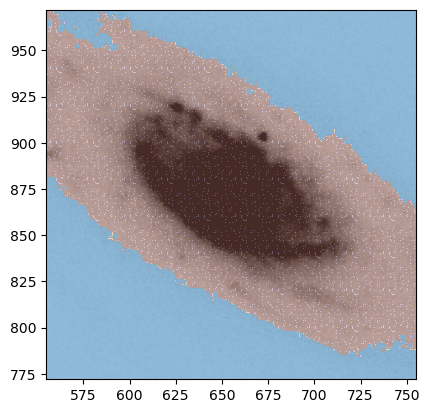

In [176]:
plt.imshow(image,vmin=bkg_med,vmax=2*bkg_med,cmap='Greys')
plt.imshow(seg_map,vmin=obj_seg-1,vmax=obj_seg+1,cmap='tab20',alpha=0.5)
plt.ylim(int(y)-100,int(y)+100)
plt.xlim(int(x)-100,int(x)+100)

109
109


(555.0, 755.0)

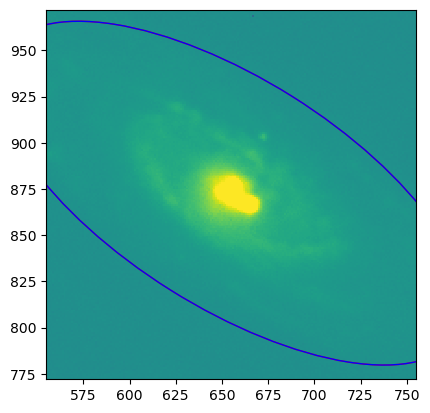

In [177]:
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='viridis',
               vmin=m-s, vmax=m+s, origin='lower')
areas=[]
# plot an ellipse for each object
for i in range(len(objects)):
    areas.append(np.pi*objects['a'][i]*objects['b'][i])
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
print(np.argmax(areas))
e1 = Ellipse(xy=(objects['x'][obj], objects['y'][obj]),
                width=6*objects['a'][obj],
                height=6*objects['b'][obj],
                angle=objects['theta'][obj] * 180. / np.pi)
e1.set_facecolor('none')
e1.set_edgecolor('blue')
ax.add_artist(e1)
print(obj)
plt.ylim(int(y)-100,int(y)+100)
plt.xlim(int(x)-100,int(x)+100)

In [178]:
mask = np.zeros(data.shape, dtype=bool)
for i in range(len(mask)):
    for j in range(len(mask[i])):
        #if seg_map[i][j]!=0:
        if (seg_map[i][j]!=obj_seg) and seg_map[i][j]!=0: 
        #if (seg_map[i][j]!=obj_seg) and (seg_map[i][j]!=obj_seg+1)and seg_map[i][j]!=0: for NGC3705, replace previous
            mask[i][j]=True

In [179]:
kronrad, krflag = sep.kron_radius(data, [x], [y], [a], [b], [theta], 6.0,segmap=seg_map,seg_id=[obj_seg])
aper=EllipticalAperture((x,y),2.5*kronrad[0]*a,2.5*kronrad[0]*b,theta)
#print(aper.area_overlap(image,mask=mask))
#print(aper.area)
phot_table = aperture_photometry(image, aper,mask=mask)
#print(phot_table['aperture_sum'])
#print(aper.area_overlap(image,mask=mask)*bkg_med)
net=phot_table['aperture_sum'][0]-aper.area_overlap(image,mask=mask)*bkg_med
print('Flux=',net)
print('S/N',net/np.sqrt(net+aper.area_overlap(image,mask=mask)*bkg_med))

Flux= 4795928.068608224
S/N 581.5859710894604


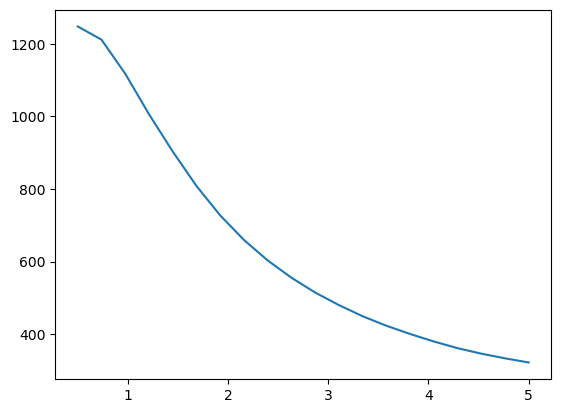

In [180]:
mult_space=np.linspace(0.5,5,20)
SNs=[]
fluxes=[]
gross_fluxes=[]
for k in mult_space:
    kronrad, krflag = sep.kron_radius(data, [x], [y], [a], [b], [theta], 6.0,segmap=seg_map,seg_id=[obj_seg])
    aper=EllipticalAperture((x,y),k*kronrad[0]*a,k*kronrad[0]*b,theta)
    phot_table=aperture_photometry(image, aper,mask=mask)
    net=phot_table['aperture_sum'][0]-aper.area_overlap(image,mask=mask)*bkg_med
    fluxes.append(net)
    gross_fluxes.append(phot_table['aperture_sum'][0]/aper.area_overlap(image,mask=mask))
    SN=net/np.sqrt(net+aper.area_overlap(image,mask=mask)*bkg_med)
    SNs.append(SN)
plt.plot(mult_space,SNs)
#plt.plot(mult_space,gross_fluxes)
#plt.axhline(y=bkg_med)

In [181]:
test=image.copy()
trues=0
for i in range(len(mask)):
    for j in range(len(mask[i])):
        #if seg_map[i][j]!=0:
        if (seg_map[i][j]!=obj_seg) and seg_map[i][j]!=0: 
        #if (seg_map[i][j]!=obj_seg) and (seg_map[i][j]!=obj_seg+1)and seg_map[i][j]!=0: for NGC3705, replace previous
            test[i][j]=bkg_med
            trues+=1
print(trues)

27888


(555.0, 755.0)

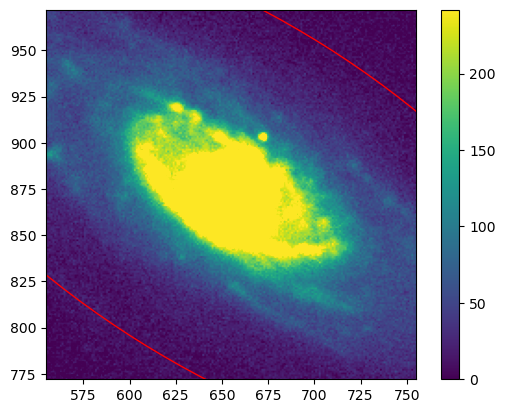

In [182]:
fig, ax = plt.subplots()
im=ax.imshow(test-bkg_med,vmin=0,vmax=bkg_med,cmap='viridis')
fig.colorbar(im)
e_app = Ellipse(xy=(x, y),
                width=2.5*kronrad*a,
                height=2.5*kronrad*b,
                angle=theta*(180/np.pi))
e_app.set_facecolor('none')
e_app.set_edgecolor('red')
ax.add_artist(e_app)
plt.ylim(int(y)-100,int(y)+100)
plt.xlim(int(x)-100,int(x)+100)